In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from igraph import *
from scipy import stats
from collections import defaultdict
from analise_breakpoints import read_file_original

In [2]:
def read_file(samples_breakpoints='data/breakpoints_k4it.max100stop.if.errorFALSE.txt'):
    samples_breakpoints = open(samples_breakpoints,'r').read().split('\n')[:-1]
    total_series = len(samples_breakpoints)
    slopes = []
    breakpoints = []
    preds = []
    idxs = []
    for i in range(0,total_series,4):
        idx = int(samples_breakpoints[i]) - 1
        
        slopes_i = [float(n) for n in samples_breakpoints[i+1].split(' ')]
        breakpoints_i = [float(n) for n in samples_breakpoints[i+2].split(' ')]
        preds_i = [float(n) for n in samples_breakpoints[i+3].split(' ')]
        idxs.append(idx)
        slopes.append(np.asarray(slopes_i))
        breakpoints.append(np.asarray(breakpoints_i))
        preds.append(np.asarray(preds_i))
    
    return np.asarray(idxs),np.asarray(slopes),np.asarray(breakpoints),np.asarray(preds)

In [3]:
def plot_hist(visualizations,filename):
    n, bins, patches = plt.hist(visualizations, 20, density=True, facecolor='g', alpha=0.75)
    plt.yscale('log')
    plt.savefig(filename)
    plt.cla()

# return indexes
def group_by_num_vis(ys,k1,k2):
    groups = defaultdict(lambda:[])
    deleted = []
    for i,y in ys.items():
        if y > k1:
            if y < k2:
                groups[1].append(i)
            else:
                groups[2].append(i)
        else:
            deleted.append(i)
    return groups,deleted

def deleted_hist():
    deleted_delta_time = []
    for d in deleted:
        x = xs[d]
        delta = x[-1]-x[0]
        deleted_delta_time.append(delta)
    plot_hist(deleted_delta_time,'hist_deleted_articles.png')

In [4]:
def breakpoints_hist():
    idxs = idxs.tolist()

    for k,v in groups.items():
        ys_v = visualizations[v]
        print(k,len(ys_v),min(ys_v),max(ys_v),np.std(ys_v))
        plot_hist(ys_v,'hist_group_'+str(k)+'.png')

        breakpoints_freq = []
        # print(v[:10])
        # print(idxs[:10])
        for i in v:
            try:
                i = idxs.index(i)
                breakpoints_freq.append(len(breakpoints[i]))
            except:
                pass
        plot_hist(breakpoints_freq,'hist_breakpoints_freq_'+str(k)+'.png')

def brusque_changes(slopes,n):
    diffs = []
    idxs = []
    for i,seq_slopes in slopes.items():
        last = seq_slopes[0]
        for slope in seq_slopes[1:]:
            diff = slope - last
            last = slope
            diffs.append(diff)
            idxs.append(i)
    ranking = np.argsort(diffs)
    topN = ranking[-n:].tolist()
    idxs = np.asarray(idxs)
    idxs = idxs[topN]
    return idxs

def calculate_ys(xs,slopes,breakpoints):
    bs = breakpoints.tolist() + [1]
    intercept_x = 0
    intercept_y = 0
    i = 0
    y = 0
    ys = []
    print(bs,slopes)
    for j,x in enumerate(xs):

        if x - bs[i] >= 0.001 and x != 1:
            i += 1

        y = (x-intercept_x)*slopes[i] + intercept_y
        print(y,'=',x,'-',intercept_x,'*',slopes[i],'+',intercept_y)
        ys.append(y)
        
        intercept_x = x
        intercept_y = y

    return ys

def plot(xs,ys,color):
    plt.scatter(xs,ys,color=color)
    
def norm(x):
    return (x-min(x))/(max(x)-min(x))

In [5]:
# filename = 'wosPlosOne2016_cocitation.xnet'
# with open(filename) as fp:  
#     line = fp.readline()
#     cnt = 1
#     while line:
#         print("Line {}: {}".format(cnt, line.strip()))
#         line = fp.readline()
#         cnt += 1
#         if cnt == 30:
#             break

In [6]:
json_file = "PlosOneData/wosPlosOne2016_citations.json"


In [7]:
xs,ys = read_file_original(filename='data/plos_one_data_total.txt')
idxs,slopes,breakpoints,preds = read_file('data/plos_one_total_breakpoints_k4_original0_data_filtered.txt')
idxs = idxs.tolist()
# slopes = np.asarray([(np.arctan(s)*57.2958) for s in slopes])

In [8]:
data = dict()
for i,s,b,p in zip(idxs,slopes,breakpoints,preds):
    data[i] = (s,b,xs[i],ys[i],p)

In [9]:
visualizations = dict()
for k,sample in data.items():
    visualizations[k] = sample[-2][-1]

In [10]:
groups,deleted = group_by_num_vis(visualizations,1000,5000)

In [11]:
for k,v in groups.items():
    print(len(v))

17870
100099


In [12]:
def get_value(data,idx,valid_idxs):
    values = dict()
    for k in valid_idxs:
        values[k] = data[k][idx]
    return values

def get_by_intervals(data,idxs):
    values = defaultdict(lambda:[])
    for k in idxs:
        sample = data[k]
        number_of_intervals = len(sample[0])
        values[number_of_intervals].append(k)
    return values

def get_values_window(xs,ys,x0,delta):
    values = []
    for x,y in zip(xs,ys):
        if x < x0+delta and x > x0-delta:
            values.append(y)
    return np.asarray(values)

def get_values_points(xs,ys,x0,num_points):
    n = len(xs)
    pos = -1
    for i in range(n-1):
        if xs[i] <= x0 and xs[i+1] > x0:
            pos = i
            break
    values = ys[max(0,pos-num_points):min(pos+num_points,n-1)]
    if pos-num_points < 0:
#         print('antes',values,pos,num_points)
        values = np.concatenate([np.zeros(abs(pos-num_points)),values])
#         print(values)
    if pos+num_points > n-1:
#         print('antes',values,pos,num_points)
        values = np.concatenate([values,np.zeros(abs(pos+num_points-n-1))])
#         print(values)
#     if len(values) != 6:
#         print(values,pos,num_points,n)
    return values

2
[10859 23650 17725 62411  5836  6041  6472 63505 25681 18396]
[0.02626363 0.48730881 0.50089862 0.94203008]


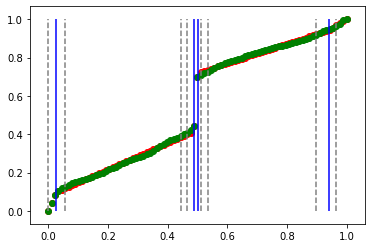

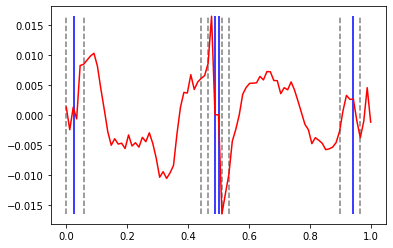

[0.37116363 0.38686793 0.53300518 0.80396747]


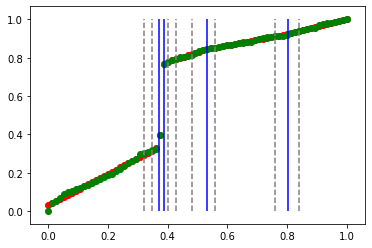

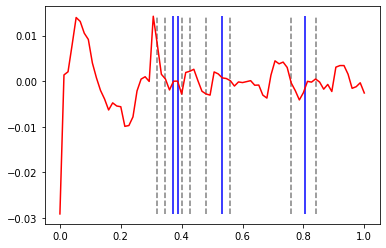

[0.07659446 0.41790345 0.43313875 0.95164094]


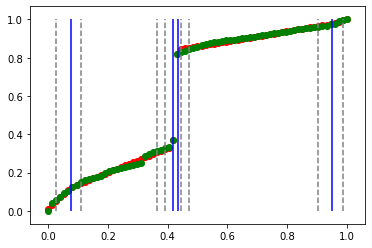

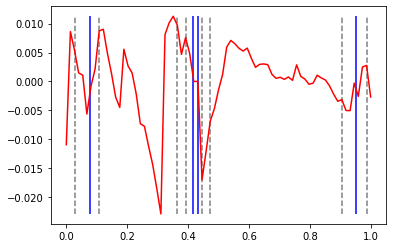

[0.19951506 0.40106192 0.72325216 0.75134678]


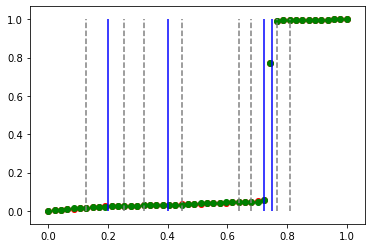

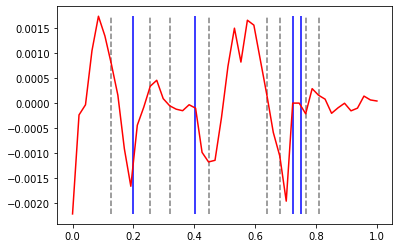

[0.0380489  0.48838598 0.50186683 0.5808816 ]


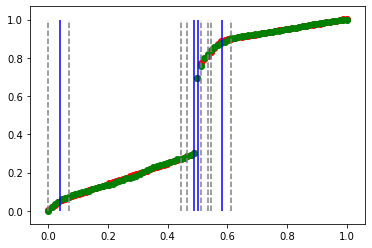

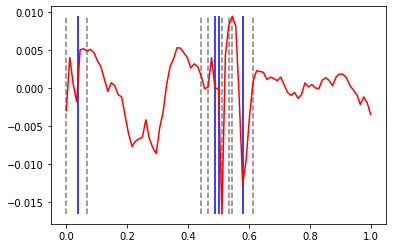

[0.02994946 0.53244672 0.54573793 0.80522676]


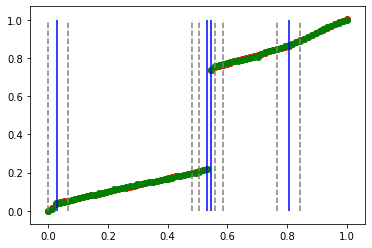

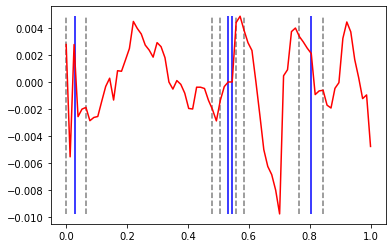

[0.27581643 0.29080872 0.62189006 0.89850403]


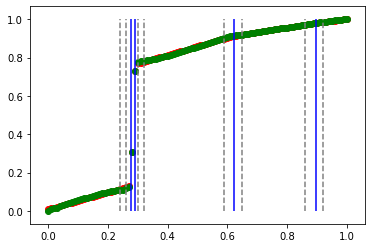

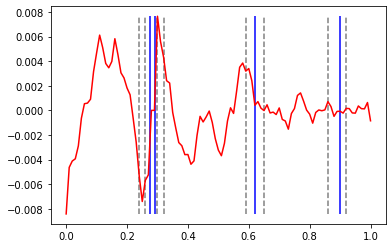

[0.13198444 0.39037888 0.66666539 0.68586329]


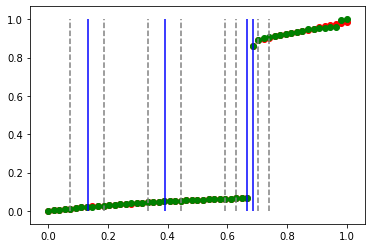

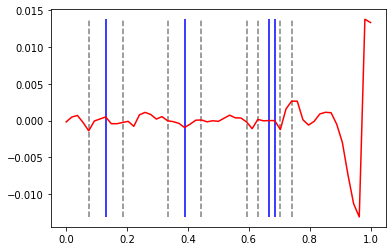

[0.08222806 0.43415189 0.44773499 0.54475018]


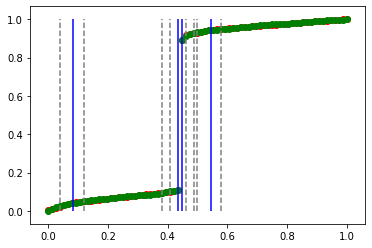

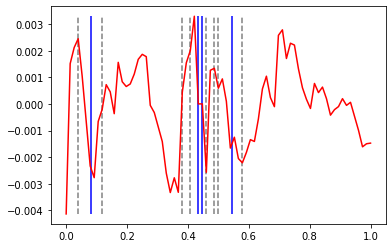

[0.15128536 0.51384245 0.52871648 0.67863337]


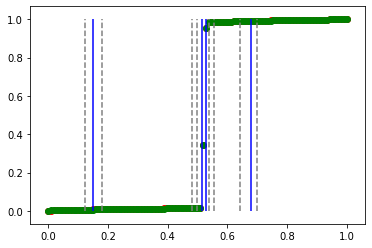

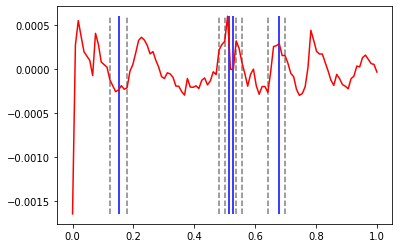

[  2460 150555  89027  33025  25797    348  16691    453  33107   9466]
[0.33511175 0.55902515 0.57662981]


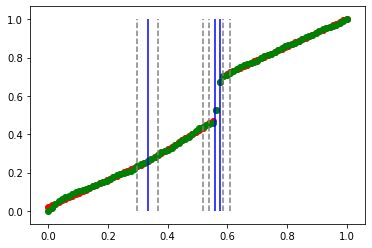

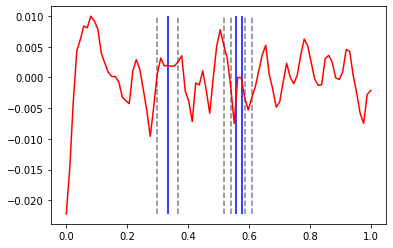

[0.05318311 0.68292139 0.73836829]


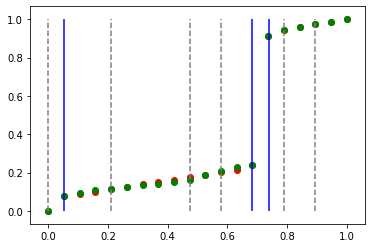

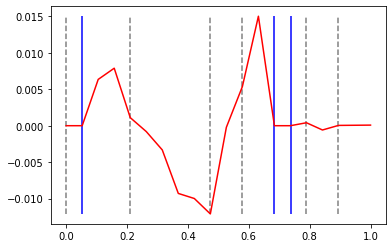

[0.25044647 0.30743421 0.80136975]


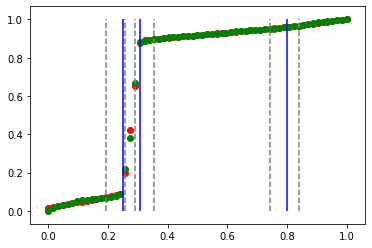

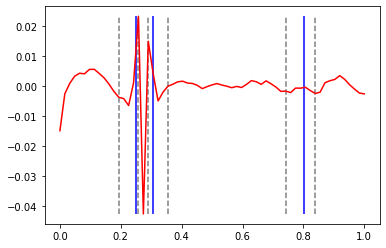

[0.20353199 0.22840801 0.43493033]


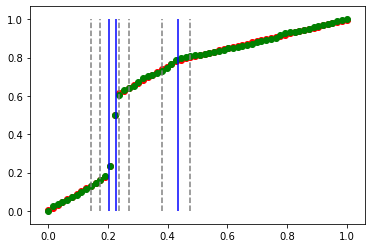

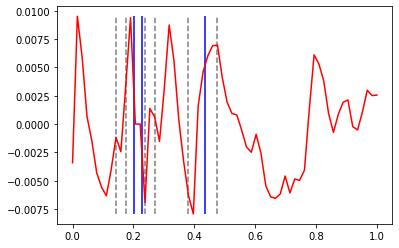

[0.24357002 0.65381816 0.69400416]


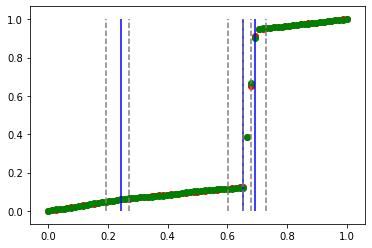

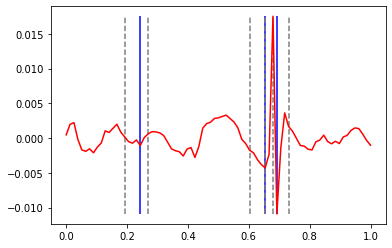

[0.28680452 0.2993153  0.83621598]


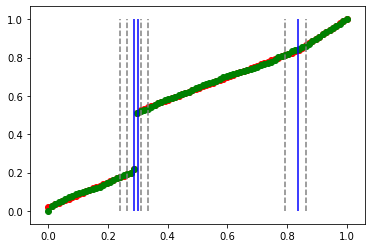

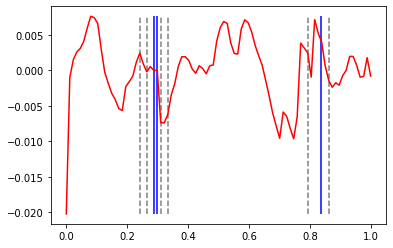

[0.43388603 0.44667199 0.8701536 ]


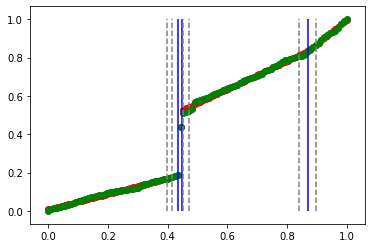

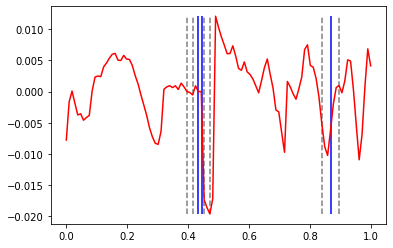

[0.05655432 0.49942131 0.50881858]


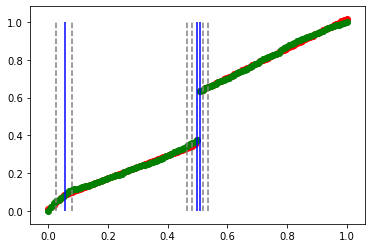

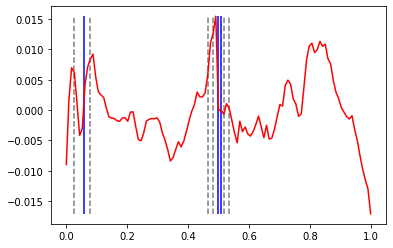

[0.42632292 0.44159853 0.83587108]


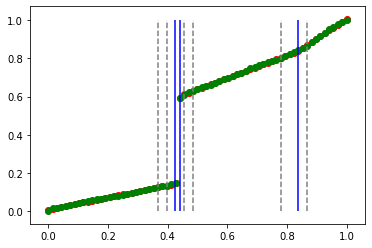

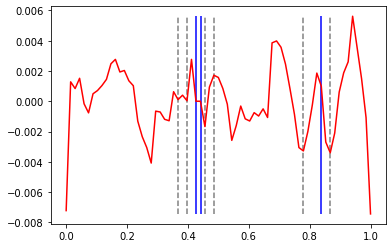

[0.43387978 0.44374001 0.86365016]


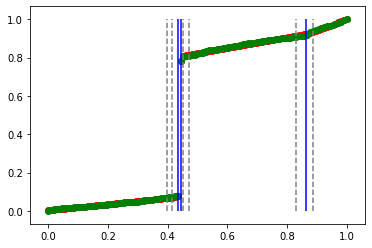

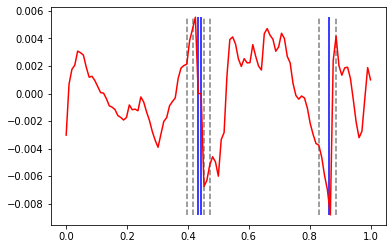

[ 97111 126245  53983  11018  50497  35474  36460  56404 133531   8016]
[0.26140002 0.79646122]


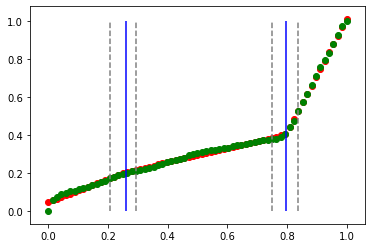

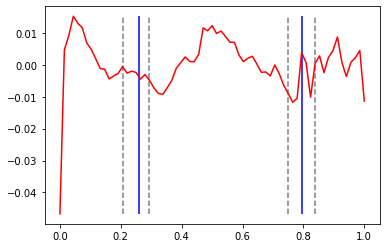

[0.31819358 0.72370326]


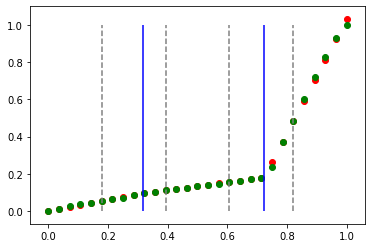

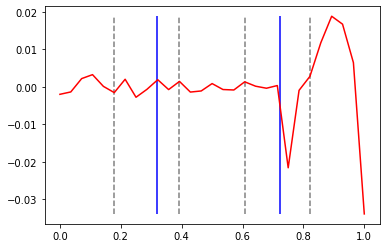

[0.1746125  0.84522774]


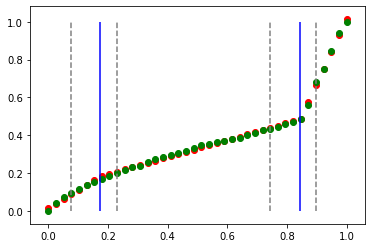

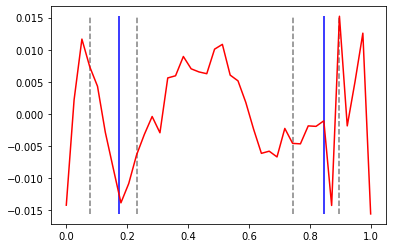

[0.57288849 0.59479197]


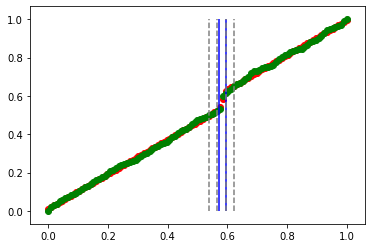

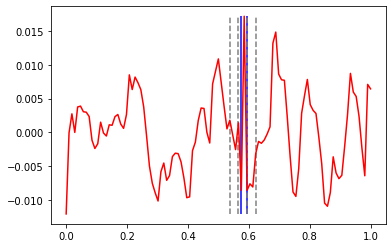

[0.67484291 0.69491997]


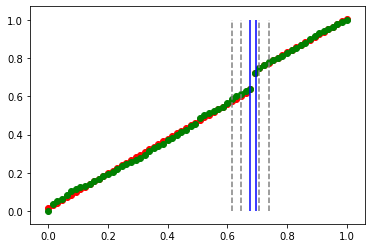

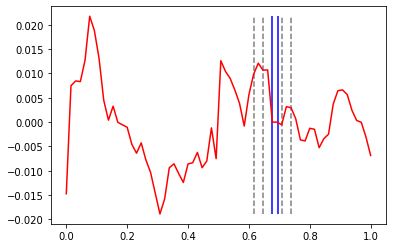

[0.41666705 0.96683159]


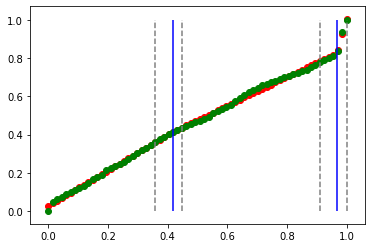

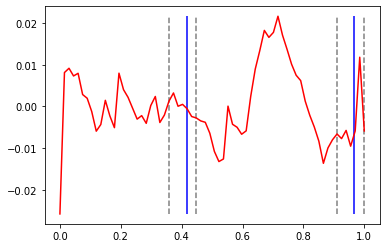

[0.30425306 0.37521543]


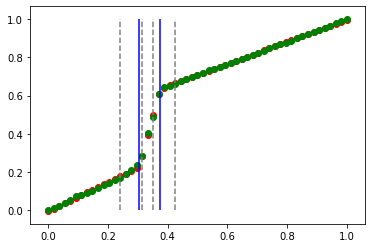

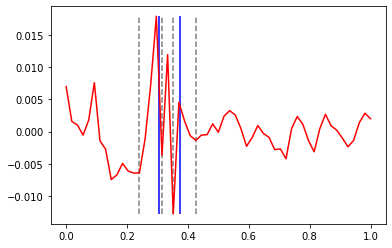

[0.23749307 0.29310489]


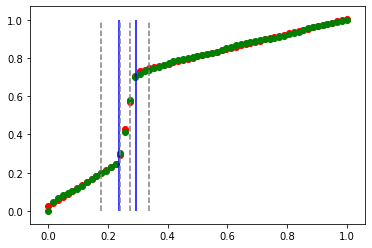

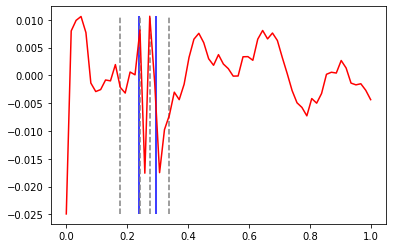

[0.43812322 0.48055372]


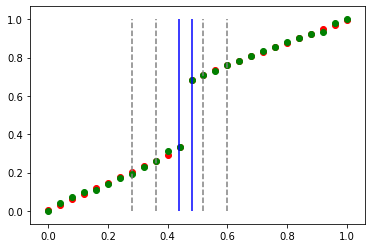

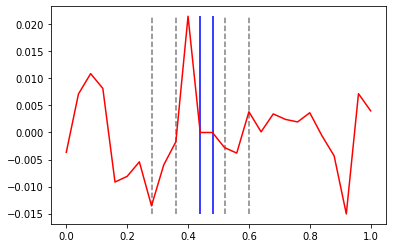

[0.5288895 0.5734757]


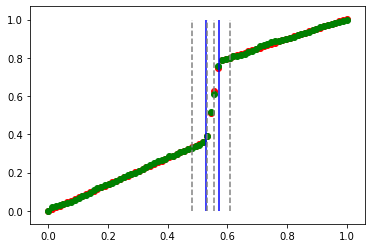

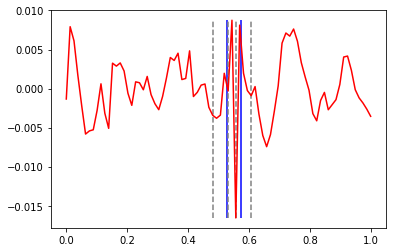

[ 30532 134830  37173  13659   5329  67146  40717  32156  52286   6971]
[0.85914131]


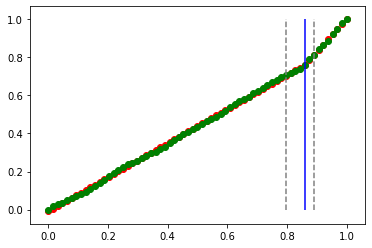

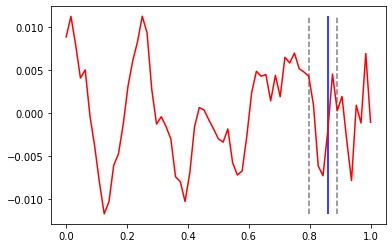

[0.51363943]


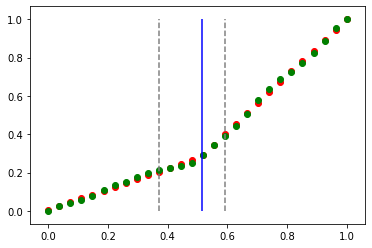

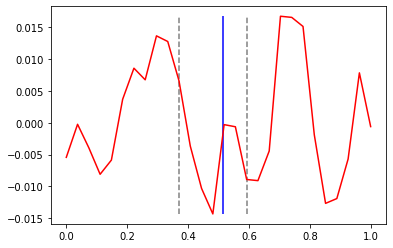

[0.74946705]


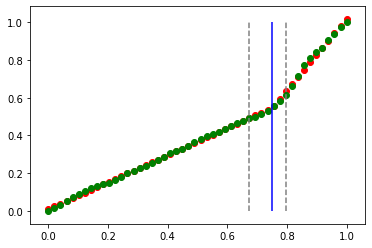

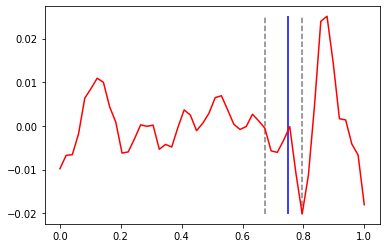

[0.81443672]


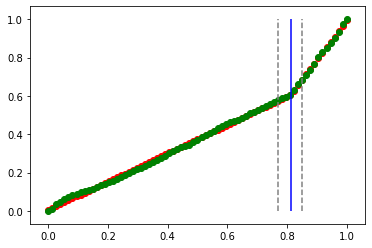

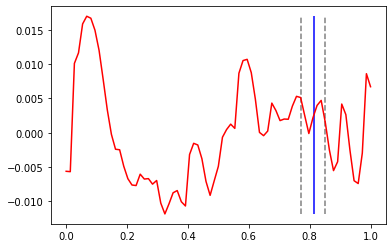

[0.87360153]


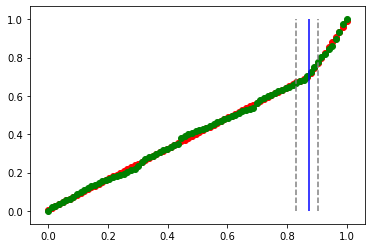

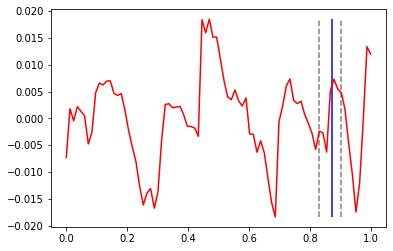

[0.71505677]


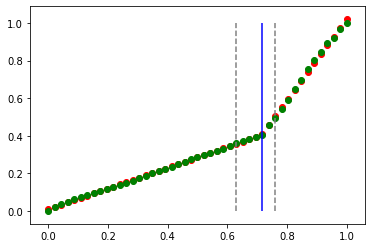

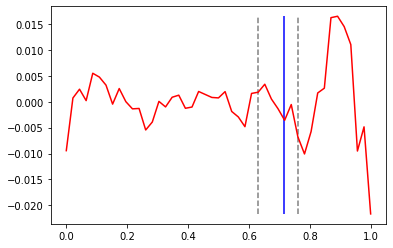

[0.81982082]


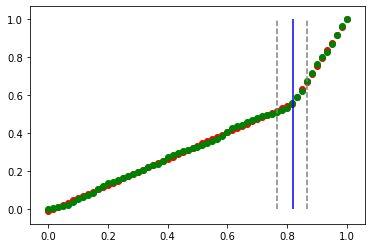

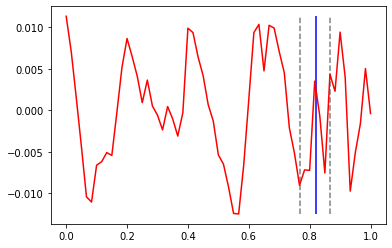

[0.81380905]


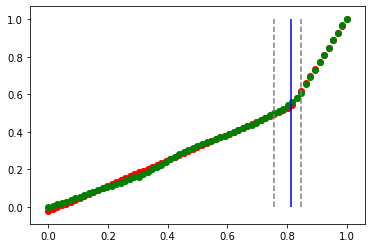

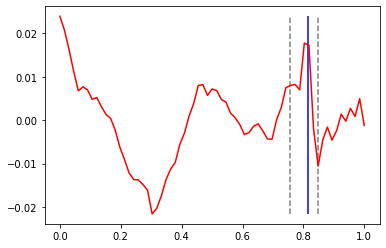

[0.79974072]


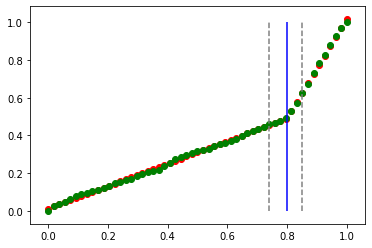

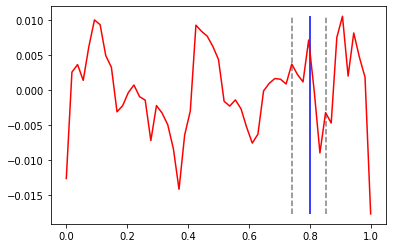

[0.8801563]


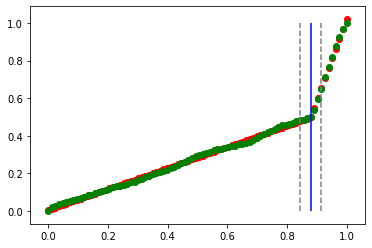

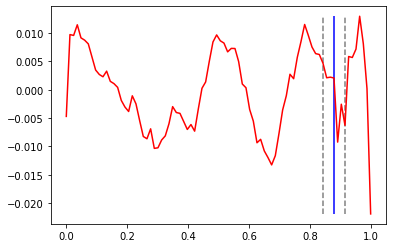

1
[ 94228  17346 110568  23887  42277  80570  14630  43401   6102  28967]
[0.08112545 0.10516655 0.18600654 0.74163366]


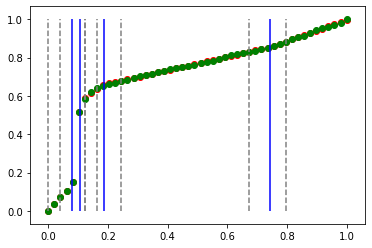

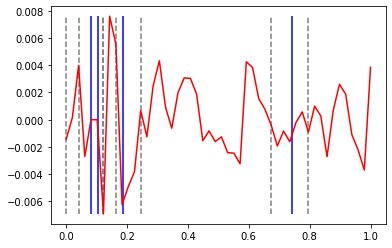

[0.21330289 0.23136281 0.72481142 0.77645469]


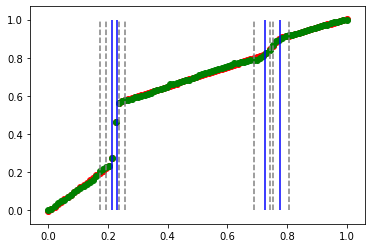

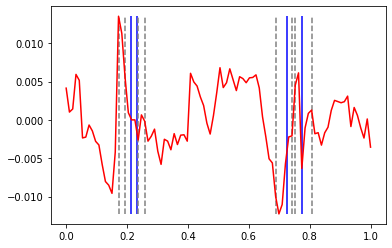

[0.19860485 0.46126853 0.62799907 0.65763864]


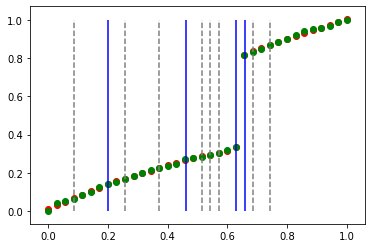

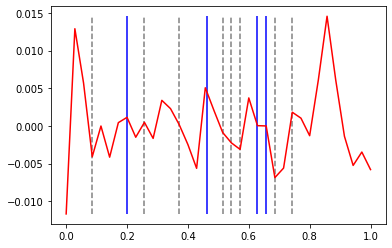

[0.2015606  0.41708682 0.44086212 0.7920309 ]


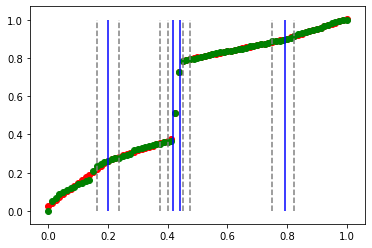

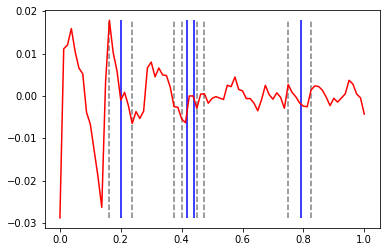

[0.0677277  0.42998672 0.63918513 0.65634052]


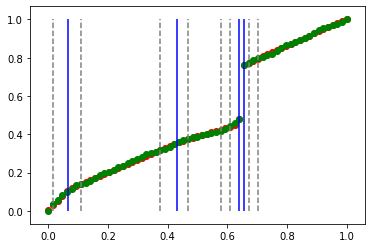

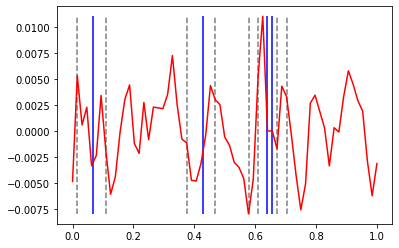

[0.2183249  0.36106384 0.75889795 0.77793143]


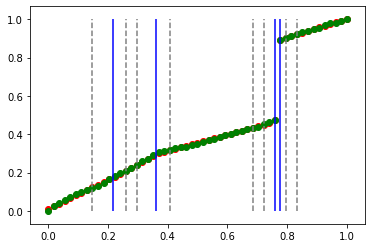

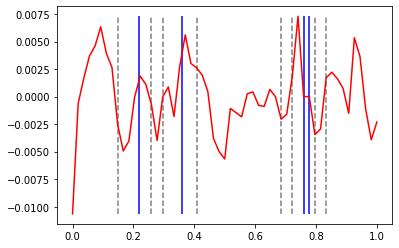

[0.30342907 0.31692384 0.6644722  0.724017  ]


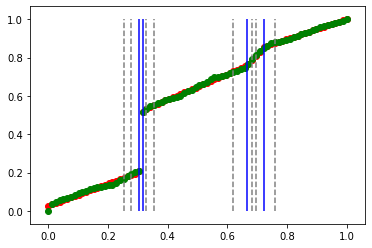

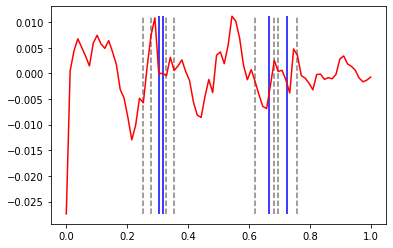

[0.05721544 0.322177   0.76776862 0.78574235]


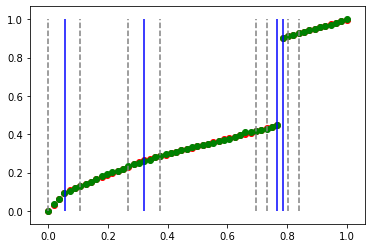

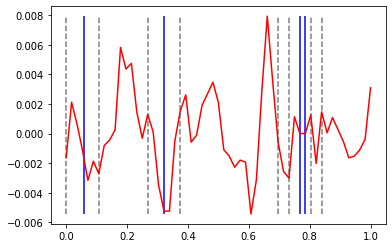

[0.27466484 0.32489579 0.75241918 0.76578007]


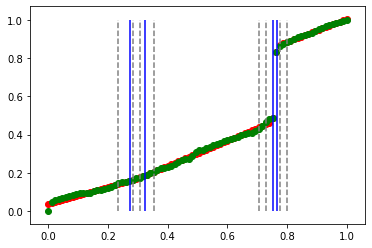

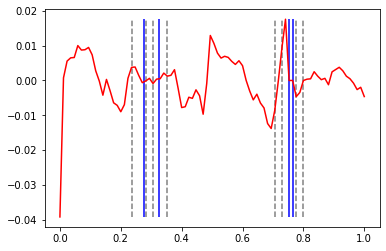

[0.22294889 0.48399112 0.49517281 0.73591355]


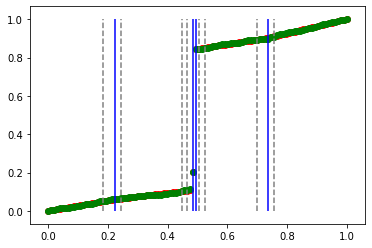

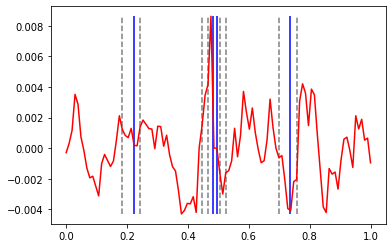

[ 88626 154095  41761 152519  28949  28575  89211  88585  91019  24216]
[0.36545566 0.39071544 0.88614365]


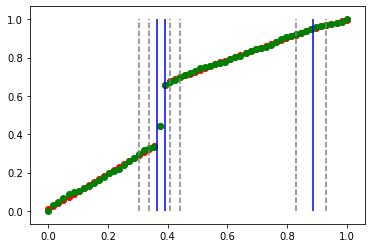

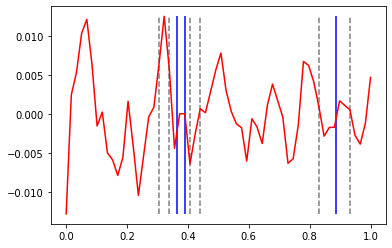

[0.09794891 0.40890772 0.45564667]


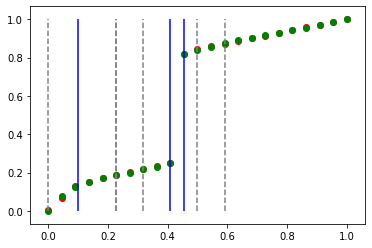

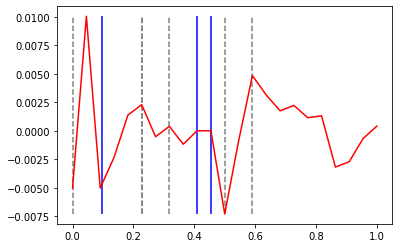

[0.36586975 0.70363051 0.72258714]


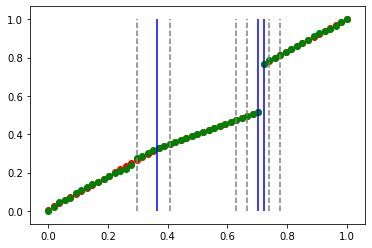

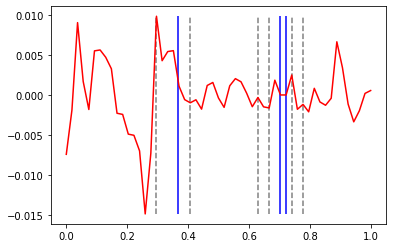

[0.44897483 0.50039183 0.89730189]


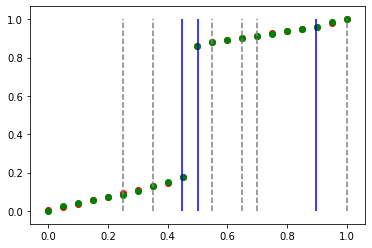

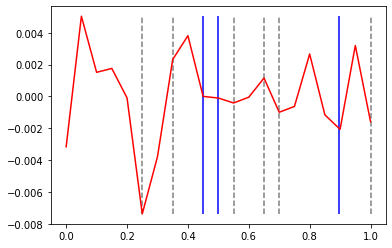

[0.10854251 0.70828548 0.72108816]


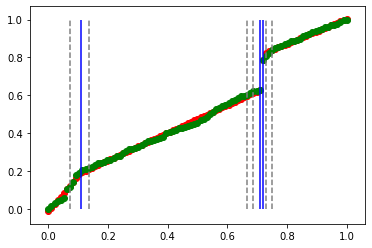

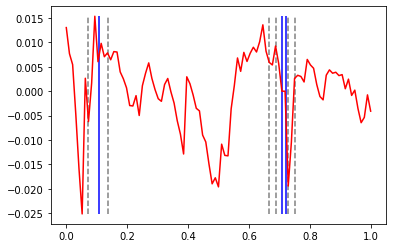

[0.08374087 0.39703362 0.42440768]


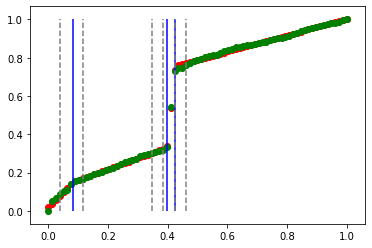

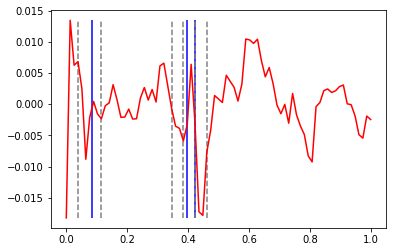

[0.47696101 0.62949042 0.65195177]


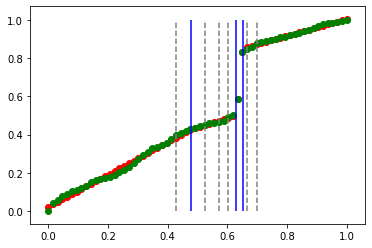

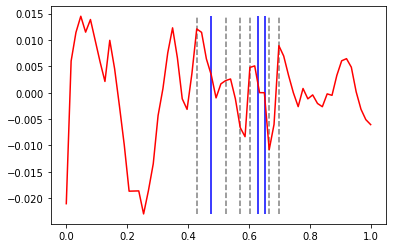

[0.02141436 0.57525139 0.59409754]


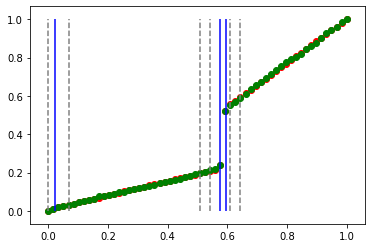

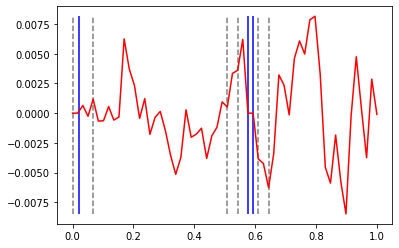

[0.08225517 0.60524144 0.63197285]


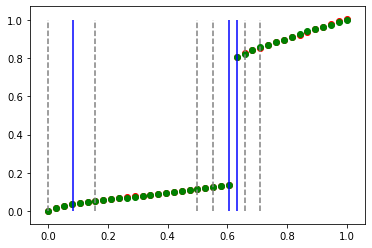

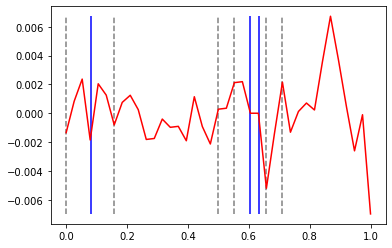

[0.27170546 0.5211301  0.53378451]


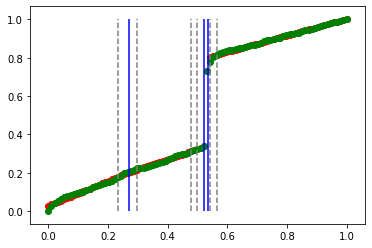

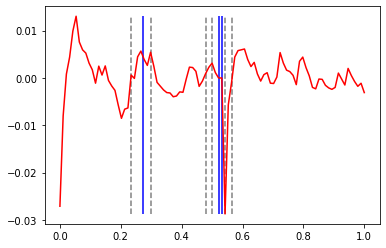

[124223 160316  92201  37294  34750 162502 101469 112141  69731  54671]
[0.20078208 0.91056743]


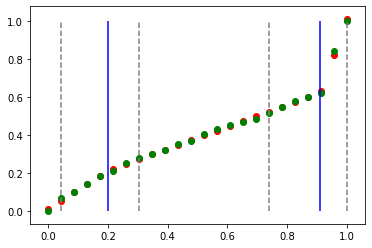

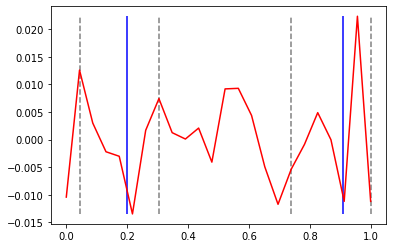

[0.08753904 0.94908041]


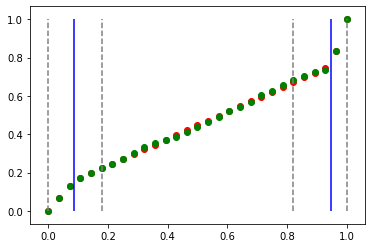

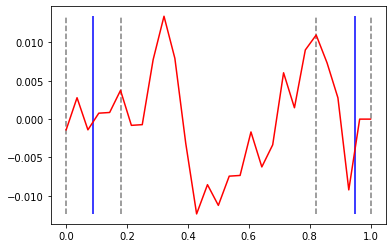

[0.17042375 0.9156285 ]


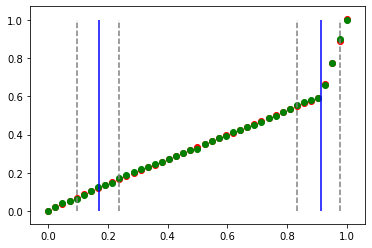

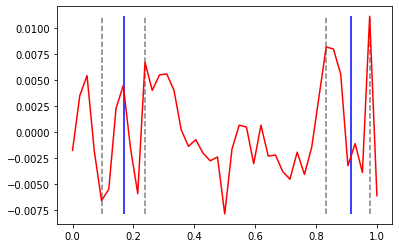

[0.13430395 0.88992801]


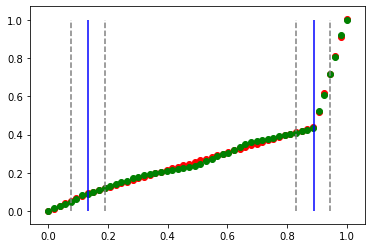

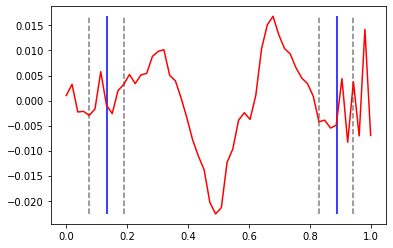

[0.26934711 0.298472  ]


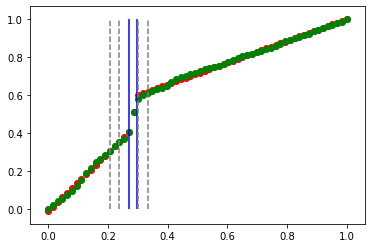

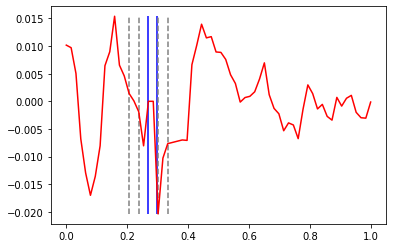

[0.36416434 0.40473975]


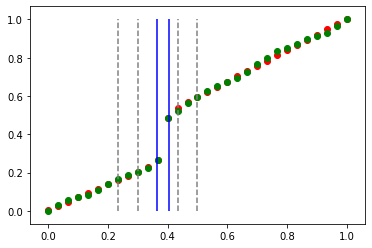

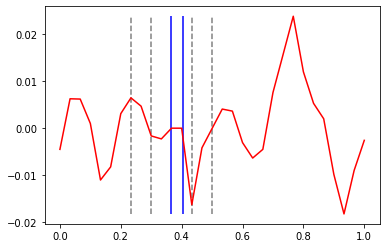

[0.32862325 0.35487919]


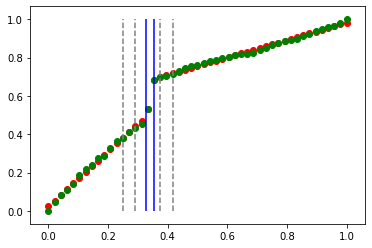

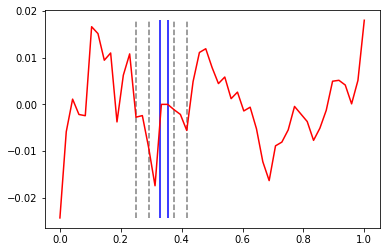

[0.05176231 0.94755022]


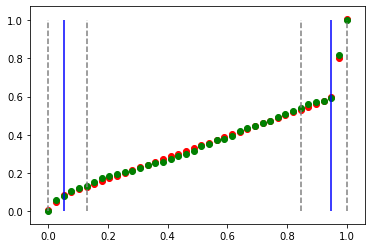

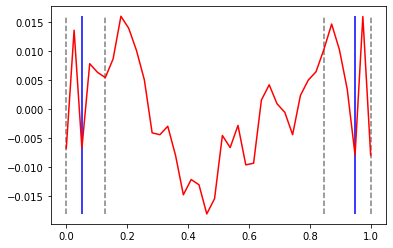

[0.23805646 0.27701605]


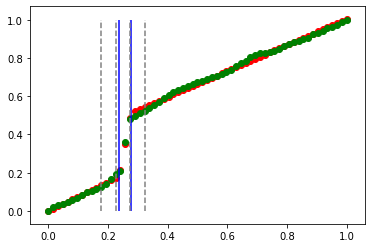

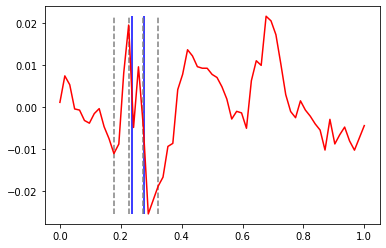

[0.40421873 0.4304339 ]


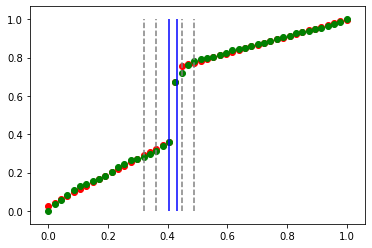

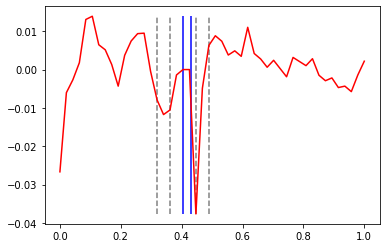

[136867 123591  90398 135931 117442  56832 148726 136394  21916 141938]
[0.6235922]


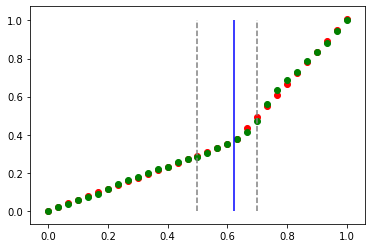

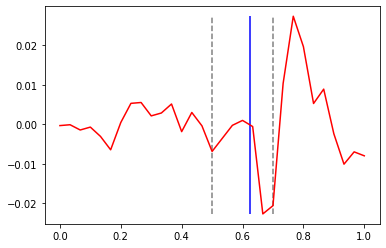

[0.77507419]


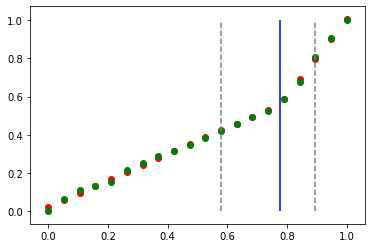

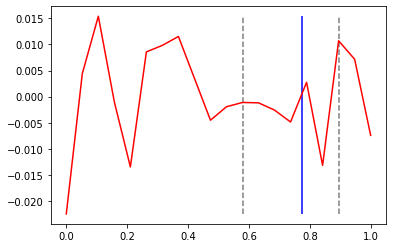

[0.66155259]


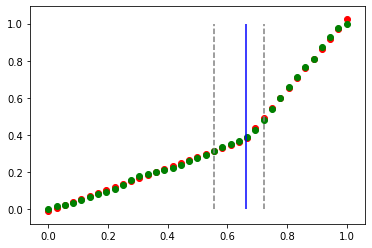

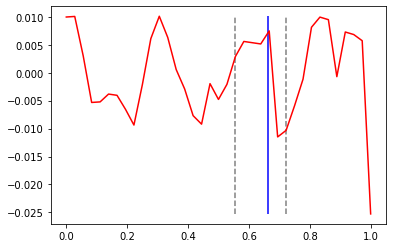

[0.53084834]


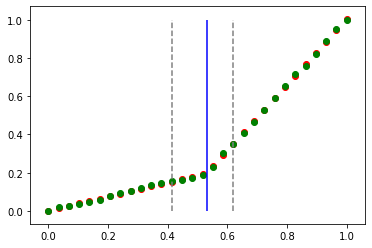

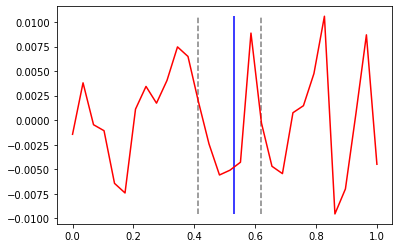

[0.68478173]


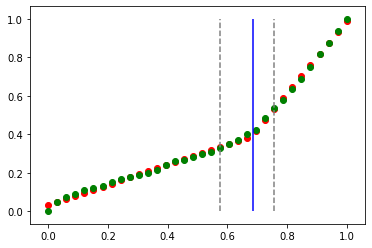

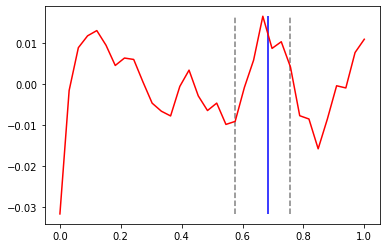

[0.78955083]


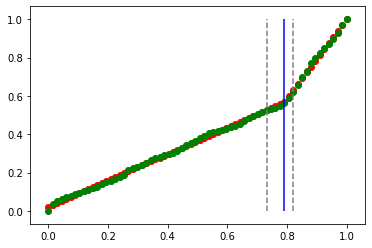

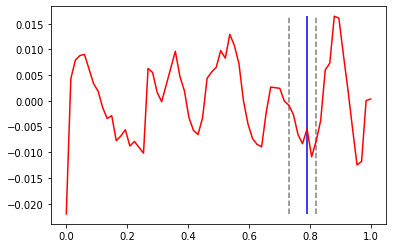

[0.70712112]


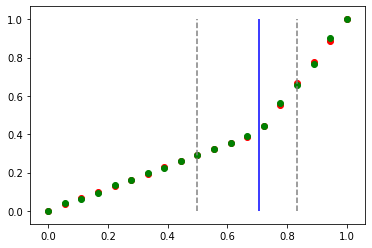

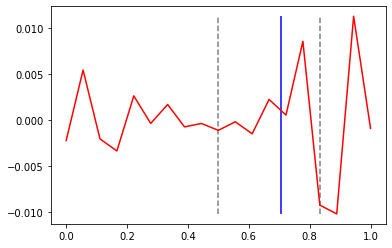

[0.85286163]


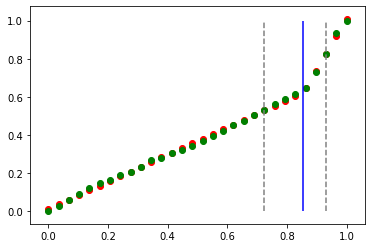

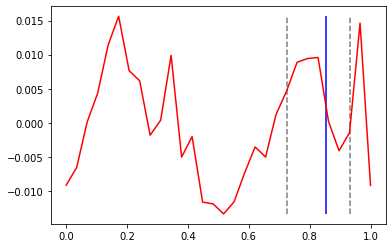

[0.83346248]


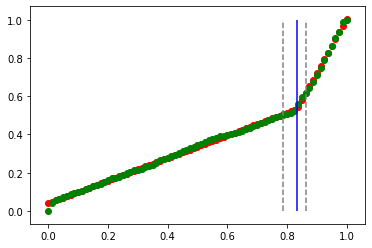

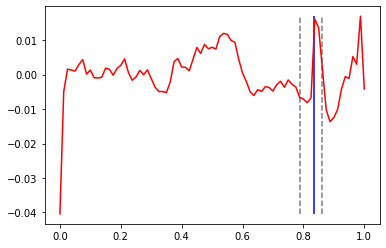

[0.71794576]


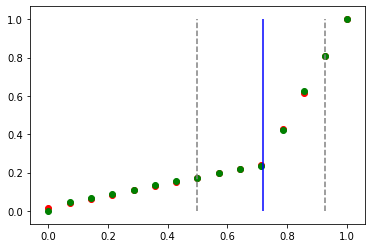

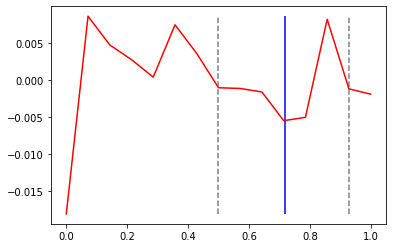

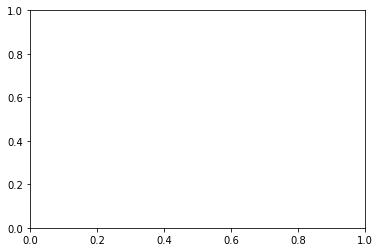

In [14]:
for k,idxs in groups.items():
    print(k)
    head = 'group'+str(k)
    deltas_std = defaultdict(lambda:[]) 
    groupby_number_intervals = get_by_intervals(data,idxs)
    for number_of_intervals,valid_idxs in groupby_number_intervals.items():
        ranking = brusque_changes(get_value(data,0,valid_idxs),10)
        print(ranking)
        for r in ranking:
            sample = data[r]
            x = norm(sample[2])
            y = norm(sample[3])
#             x = sample[2][1:]
#             y = sample[3][1:]
            
            y_pred = sample[-1]
            bpoints = sample[1]
            slopes = sample[0]
            
            print(bpoints)
            plot(x,y_pred,'red')
            plot(x,y,'green')
            plt.vlines(bpoints,ymin=min(y),ymax=max(y),color='blue')
            n = len(x)
            for b in bpoints:
                for i in range(n-1):
                    if x[i] <= b and x[i+1] > b:
                        pos = i
                        break
#                     print(i,[x[pos-2],b,x[pos+2]])
#                     print(x)
                plt.vlines([x[max(0,pos-3)],x[min(pos+3,len(x)-1)]],ymin=min(y),ymax=max(y),color='gray',linestyle='--')
            plt.savefig('imgs_python/preds/'+head+'/original_pred_'+str(number_of_intervals)+'_'+str(r)+'.png')
            plt.show()
            plt.cla()
            
            plt.vlines(bpoints,ymin=min(y-y_pred),ymax=max(y-y_pred),color='blue')
            n = len(x)
            for b in bpoints:
                for i in range(n-1):
                    if x[i] <= b and x[i+1] > b:
                        pos = i
                        break
                plt.vlines([x[max(0,pos-3)],x[min(pos+3,len(x)-1)]],ymin=min(y-y_pred),ymax=max(y-y_pred),color='gray',linestyle='--')
            plt.plot(x,y-y_pred,color='red')
            plt.savefig('imgs_python/preds/'+head+'/original_pred_'+str(number_of_intervals)+'_'+str(r)+'_diff.png')
            plt.show()
            plt.cla()

In [15]:
def hist_delta_std(window_value,get_values):
    count = 0
    deltas_std = defaultdict(lambda:[]) 
    deltas_points = defaultdict(lambda:[])
    for k,idxs in groups.items():
        head = 'group'+str(k)
#         groupby_number_intervals = get_by_intervals(data,idxs)
#         for number_of_intervals,valid_idxs in groupby_number_intervals.items():
#             for idx in valid_idxs:
        for idx in idxs:
            sample = data[idx]
            x = norm(sample[2])
            y = norm(sample[3])
            y_pred = sample[-1]
            bpoints = sample[1]
            slopes = sample[0]

            for i,b in enumerate(bpoints):
                vs = get_values(x,y,b,window_value)
                std = np.std(vs)
                slope_diff = slopes[i+1]-slopes[i]
                count += 1
                key = 1 if slope_diff > 0 else -1
                deltas_std[key].append(std)
                deltas_points[key].append(vs)
#     print(count)
    return deltas_std,deltas_points

In [16]:
def hists(delta,get_values):
    deltas_std,deltas_points = hist_delta_std(delta,get_values)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3),sharey=True)
    curve_pos_std = np.nanmean(deltas_std[1])
    ax1.hist(deltas_std[1], 10, density=True, facecolor='g', alpha=0.75, range=(0,0.1))
    ax1.set_title('Curve (positive) std mean = %.4f '% curve_pos_std)
    
    curve_neg_std = np.nanmean(deltas_std[-1])
    ax2.hist(deltas_std[-1], 10, density=True, facecolor='g', alpha=0.75,range=(0,0.1))
    ax2.set_title('Curve (negative) std mean = %.4f '% curve_neg_std)
    fig.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3),sharey=True)
    ys1 = np.nanmean(deltas_points[1],axis=0)
    std1 = np.nanstd(deltas_points[1],axis=0)
    print(std1)
#     print('ys1',ys1)
#     print('min',np.nanmin(deltas_points[1],axis=0),'max',np.nanmax(deltas_points[1],axis=0))
    xs = list(range(len(ys1)))
    ax1.errorbar(xs,ys1,yerr=std1)
    ax1.scatter(xs,ys1)
    ax1.set_title('Curve (positive)')
    
    ys2 = np.nanmean(deltas_points[-1],axis=0)
    std2 = np.nanstd(deltas_points[-1],axis=0)
    print(std2)
#     print(deltas_points[-1][:10])
#     print(deltas_points[-1][-10:])
#     print('ys2',ys2)
#     print('min',np.nanmin(deltas_points[-1],axis=0),'max',np.nanmax(deltas_points[-1],axis=0))
    xs = list(range(len(ys2)))
    ax2.errorbar(xs,ys2,yerr=std2)
    ax2.scatter(xs,ys2)
    ax2.set_title('Curve (negative)')
    fig.show()

In [ ]:
hists(0.01,get_values_window) # não funciona

In [ ]:
hists(0.02,get_values_window)

In [ ]:
hists(0.03,get_values_window)

/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


[0.21121511 0.20919095]
[0.26226918 0.24912609]


/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


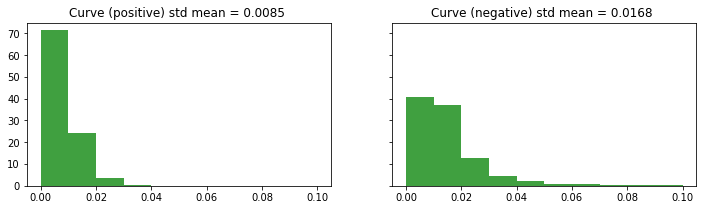

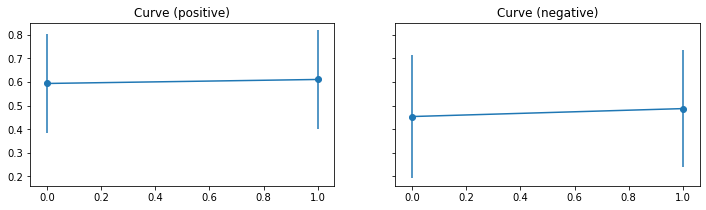

In [18]:
hists(1,get_values_points)

/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


[0.21343331 0.21121511 0.20919095 0.20709289]
[0.26847651 0.26226918 0.24912609 0.24347135]


/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


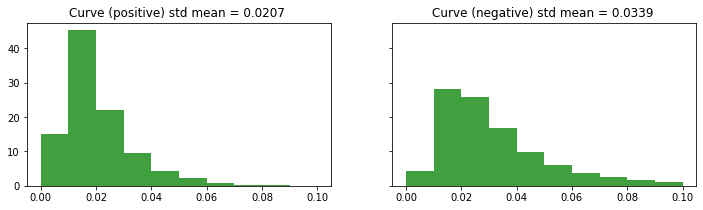

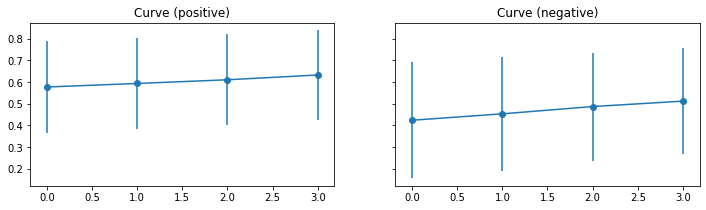

In [19]:
hists(2,get_values_points)

/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


[0.2160591  0.21343331 0.21121511 0.20919095 0.20709289 0.22721479]
[0.27123226 0.26847651 0.26226918 0.24912609 0.24347135 0.24031284]


/home/carol/.local/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


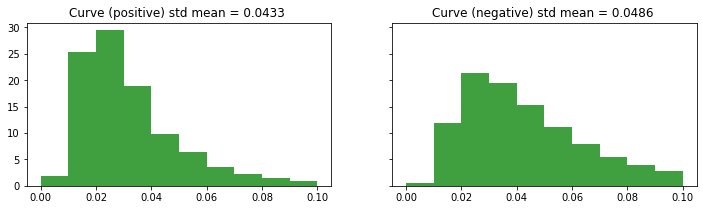

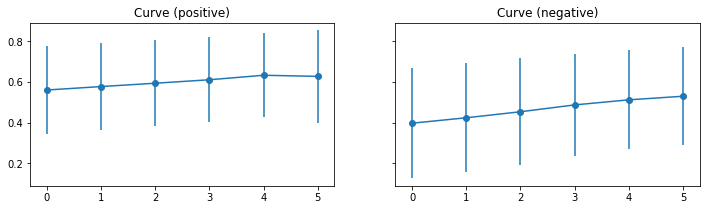

In [20]:
hists(3,get_values_points)

In [ ]:
# janela de pontos vs a curva (se está captando a diferença)

In [18]:
#errorbar ok
#sem normalizar (refazer)
#agrupar usando medida do paper